## Initialization

In [1]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Constants

In [2]:
PROJECT_ROOT = 'absolute-path-of-project-root'
TRAIN_MBTR_DIR = PROJECT_ROOT + "/data/processed/training_set/features"
TEST_MBTR_DIR = PROJECT_ROOT + "/data/processed/test_set/features"
TRAIN_SASA_DIR = PROJECT_ROOT + "/data/processed/training_set/label"
TEST_SASA_DIR = PROJECT_ROOT + "/data/processed/test_set/label"
MODELS_DIR = PROJECT_ROOT + "/models"
PLOTS_DIR = PROJECT_ROOT + "/plots"
WINDOW_SIZE = 40
SAVE_MODELS = False
RANDOM_STATE = 123

## Imports

In [3]:
import numpy as np
import pandas as pd
import os
from joblib import dump, load
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import copy
import keras
from numpy.lib.stride_tricks import sliding_window_view
import random
from sklearn.model_selection import KFold
import pickle
import re
import matplotlib.pyplot as plt

# models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## Helper Functions

In [4]:
def evaluate_results(y, y_hat, return_values = False, show_outputs = True):
  if len(y.shape) > 2:
    y = y.reshape((y.shape[0], -1))
    y_hat = y_hat.reshape((y_hat.shape[0], -1))
  mae = mean_absolute_error(y, y_hat)
  mse = mean_squared_error(y, y_hat)
  rmse = mean_squared_error(y, y_hat, squared=False)
  if show_outputs:
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
  if return_values:
    return mae, mse, rmse

In [5]:
def load_model(model_name, num_feature, directory):
    """
    Loads the sepcified model and returns the object representing that model.

    This function is a utility function that loads any of the models used in
    this project. The function reads the model from the specified directory
    through methods applicable to the type of model.

    Parameters
    ----------
    model_name : str
        ``transfomer`` or``ensemble_model``, for simulation part or
        ``sasa_model`` for SASA calculation
    num_feature : int
        Number of features in the training data
    directory : str
        absolute or relative directory for saving the models

    Returns
    -------
    object
        The object of the corresponding model's class
    """
    if model_name == 'transformer' or model_name == 'sasa_model':
        model = keras.models.load_model(directory)
        return model
    elif model_name == 'ensemble':
        model = ensemble_model(num_feature)
        model.load_model(directory)
        return model

In [6]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

In [7]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_pc(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()
    y_pred.append(pred_sasa)
    y_true.append(y_test[(i+1) * timestep - 1])

  return mean_absolute_error(y_true, y_pred)

In [8]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_mbtr(mbtr_model, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)

  error = 0
  sim_steps = timestep - window_size - 1
  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    y_pred.append(data[-1])
    y_true.append(x_test[(i+1) * timestep - 1])

    # error = error + np.sum(np.abs(data[-1] - x_test[(i+1) * timestep - 1]))

  return mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred, squared=False)

## Load Data

In [9]:
def mbtr_ds_generator(directory):
  """
  Creates a dataset of the MBTR vectors.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. All the
  vectors are gathered in a dataset along with the duration of the
  simulations for the designs.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets

  Returns
  -------
  x : array of floats; shape (number of designs * duration, num_feature)
      The vector array of all the MBTRs in a sequence stacked row-wise
  timestep_size : list of int
      duration of each design for the MBTR files in the directory
  """
  ptr = 0
  timestep_size = []
  if directory[-1] != '/':
    directory = directory + '/'
  for mbtr_file in sorted(os.listdir(directory)):
    x_mbtr = pd.read_csv(directory + str(mbtr_file))
    timestep_size.append(x_mbtr.shape[0])
    if ptr == 0:
      x = np.array(x_mbtr.values.tolist())
      ptr = 1
    else:
      x = np.concatenate((x, np.array(x_mbtr.values.tolist())), axis = 0)
    # print("MBTR: ", mbtr_file, "Shape:", x.shape)

  # print("MBTR Shape:", x.shape)
  # print("timesteps: ", len(timestep_size))
  return x, timestep_size

def sasa_ds_generator(directory):
  """
  Creates a dataset of SASA values.

  This function reads all CSV data files containing the SASA values
  corresponding to different design configurations at different states.
  All the values are gathered in a dataset.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the SASA CSV datasets

  Returns
  -------
  array of floats; shape (number of designs * duration,)
      The array of all the SASA values in a sequence stacked row-wise
  """
  ptr = 0
  if directory[-1] != '/':
    directory = directory + '/'
  for sasa_file in sorted(os.listdir(directory)):
    # print("SASA: ", sasa_file)
    x_sasa = pd.read_csv(directory + str(sasa_file), sep=';')
    if ptr == 0:
          x = np.array(x_sasa['TOTAL'])
          ptr = 1
    else:
          x = np.concatenate((x, np.array(x_sasa['TOTAL'])), axis = 0)
  # print("SASA Shape:", x.shape)
  return x

def mbtr_mbtr_ds_generator(directory, window_size, sasa_dir = None, shuffle = False):
  """
  Creates a windowed dataset of the MBTR vectors, and SASA values if specified.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. Then,
  generates a sliding window based dataset pair of MBTRs. If specified
  the SASA values are also recorded.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets
  window_size: int
      The window size to create the data pairs
  sasa_dir : str or None; default: None
      absolute or relative directory of the SASA CSV datasets,
      if ``None`` SASA values are not considered
  shuffle : bool
      Used to decide whether or not to shuffle the data order

  Returns
  -------
  dataset_x : array of floats; shape (number of samples, window_size, num_feature)
      The vector array of all the MBTRs stacked in sliding window method
  dataset_y : array of floats; shape (number of samples, num_feature)
      The array of MBTR vectors of the next timesteps of the window
  y_sasa : arrary of floats;  shape (number of samples, 1)
      The array of all the SASA values for the next timesteps of the window
  sasa_zero : array of float; shape (number of designs, 1)
      The array of initial SASA values (1st timestep) for each design configuration
  """
  dataset_x = []
  dataset_y = []
  y_sasa = []
  sasa_zero = []
  i = 0
  j = 0
  mbtr, timestep_size = mbtr_ds_generator(directory)
  if sasa_dir is not None:
    sasa = sasa_ds_generator(sasa_dir)
    if shuffle == True:
      idx = np.arange(mbtr.shape[0])
      np.random.shuffle(idx)
      mbtr = mbtr[idx]
      sasa = sasa[idx]
    assert mbtr.shape[0] == sasa.shape[0], "MBTR and SASA have mismatching shapes"
  elif shuffle == True:
    np.random.shuffle(mbtr)

  for i in range(len(timestep_size)):
    if i == 0:
        z = 0
    else:
        z = sum(timestep_size[:i])
    for j in range(z, z + timestep_size[i] - window_size):
      dataset_x.append(mbtr[j : j + window_size])
      dataset_y.append(mbtr[j + window_size])
      if not sasa_dir is None:
        y_sasa.append(sasa[j + window_size])
    if not sasa_dir is None:
      sasa_zero.append(sasa[z])
  if not sasa_dir is None:
    return np.array(dataset_x), np.array(dataset_y), np.array(y_sasa), np.array(sasa_zero)
  return np.array(dataset_x), np.array(dataset_y)

def get_X_predicted_and_y(mbtr_model):
  X, timesteps = mbtr_ds_generator(TRAIN_MBTR_DIR)
  Y = sasa_ds_generator(TRAIN_SASA_DIR)
  X_predicted = []
  labels = []
  for i in range(len(timesteps)):
    start = sum(timesteps[:i])
    end = start + timesteps[i] - 1
    current_data = X[start:start+WINDOW_SIZE]
    current_position = start + WINDOW_SIZE
    while current_position < end:
      X_predicted.append(mbtr_model.predict(np.expand_dims(current_data, axis=0)))
      labels.append(Y[current_position])
      current_data = np.concatenate((current_data[1:], X_predicted[-1]), axis=0)
      current_position = current_position + 1
  return np.array(X_predicted), np.array(labels)

## Train models

In [10]:
x_train, y_train, y_sasa_train, sasa_zero_train = mbtr_mbtr_ds_generator(TRAIN_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TRAIN_SASA_DIR, shuffle = False)
x_test, y_test, y_sasa_test, sasa_zero_test = mbtr_mbtr_ds_generator(TEST_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TEST_SASA_DIR, shuffle = False)
# y_train = sasa_ds_generator(TRAIN_SASA_DIR)
# y_test = sasa_ds_generator(TEST_SASA_DIR)
x_train.shape, y_train.shape, y_sasa_train.shape, x_test.shape, y_test.shape, y_sasa_test.shape

((20480, 40, 72), (20480, 72), (20480,), (3120, 40, 72), (3120, 72), (3120,))

In [11]:
x_train.std()

2920.762030980812

In [12]:
x_train_standardized = (x_train - x_train.mean()) / x_train.std()
x_test_standardized = (x_test - x_train.mean()) / x_train.std()
x_train_standardized.shape, x_test_standardized.shape

((20480, 40, 72), (3120, 40, 72))

### MBTR Training

#### Evaluate ensemble model

In [13]:
class ensemble_model():
  """
  A class that manages all functionality of the ensemble model.

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  x_models : list of XGBRegressor.model objects
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, max_depth=6, max_leaves=0, learning_rate=0.3):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one XGBoost model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    x_models : list of XGBRegressor.model objects
        List of models in order representing each feature
    num_feature : int
        Number of features in the training data
    """
    self.x_models = []
    self.num_feature = num_feature
    for i in range(self.num_feature):
      self.x_models.append(XGBRegressor(objective='reg:squarederror',
                                        n_jobs=-1,
                                        verbosity=1,
                                        max_depth=max_depth,
                                        max_leaves=max_leaves,
                                        learning_rate=learning_rate,
                                        device='gpu'))

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the x_models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.x_models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the x_models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.x_models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def evaluate(self, x, y):
    """
    Provides the avearge of mean absolute error values for all the models for passed data

    This function reads each model from the x_models attribute, predicts the
    outcome, measures MAE for each model and calculates the average.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for evaluation
    y : array of float; shape (number of samples, num_feature)
        Label Vector for MAE calculation

    Returns
    -------
    float
        The avaerage MAE for the passed data
    """
    pred_error = []
    for i in range(x.shape[0]):
        prediction = self.predict(x[i])
        pred_error.append(mean_absolute_error(np.expand_dims(y[i], axis = 0), prediction))
    avg_mae = np.mean(pred_error)
    return avg_mae

  def save(self, directory):
    """
    Saves the models from the x_models attribute into specified dirctory.

    Parameters
    ----------
    directory : str
        absolute or relative directory for saving the models
    """
    try:
        os.mkdir(directory)
    except OSError as error:
        pass
    if directory[-1] != '/':
        directory = directory + '/'
    for i in range(self.num_feature):
      dump(self.x_models[i], directory + 'xgbmodel_' + str(i).zfill(2) + '.joblib')

  def load_model(self, directory):
    """
    Loads the models from specified dirctory and updates the x_models attribute.

    Parameters
    ----------
    directory : str
        absolute or relative directory for saving the models
    """
    if directory[-1] != '/':
        directory = directory + '/'
    self.x_models = []
    for i in range(self.num_feature):
      x_model = load(directory + 'xgbmodel_' + str(i).zfill(2) + '.joblib')
      self.x_models.append(x_model)

In [14]:
xgb_model = load_model('ensemble', 72, PROJECT_ROOT + '/models/ensemble/')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:37:30] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:37:30] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:37:31] WARNING: /workspace/sr

In [ ]:
x_train.shape, y_train.shape

((20480, 40, 72), (20480, 72))

In [ ]:
y_train_pred = (xgb_model.predict(x_train))
print(y_train_pred.shape)
y_test_pred = (xgb_model.predict(x_test))
print(y_test_pred.shape)

(20480, 72)
(3120, 72)


In [ ]:
ensemble_model_y_train_pred = copy.deepcopy(y_train_pred)
ensemble_model_y_test_pred = copy.deepcopy(y_test_pred)

In [ ]:
print("Train set: ")
evaluate_results(y_train, y_train_pred)
print("Test set: ")
evaluate_results(y_test, y_test_pred)

Train set: 
MAE:  0.8970804831139318
MSE:  19.953589806755133
RMSE:  1.1626177459367903
Test set: 
MAE:  1.7294093450352332
MSE:  66.12916281825518
RMSE:  2.8218720217300564


In [15]:
print("Test set error of last timestep: ", calc_error_mbtr(xgb_model))

Test set error of last timestep:  (6.70420570431563, 9.138830041244907)


#### Train different machine learning models

In [ ]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

In [ ]:
models = [LinearRegression,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          ExtraTreesRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'XGB',
                'AdaBoost',
                'GBM',
                'ETR',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

In [ ]:
indices = list(range(len(x_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = ensemble_model_custome(72, models[i], models_names[i])

  print("Model Name: ", models_names[i])

  if model.model_exists():
    model.load_model()
  else:
    model.train(x_train[indices], y_train[indices])

  print("Train set: ")
  evaluate_results(model.predict(x_train), y_train)
  print("Test set: ")
  evaluate_results(model.predict(x_test), y_test)
  print("Test set error of last timestep: ", calc_error_mbtr(model))

  if not model.model_exists() and SAVE_MODELS == True:
    model.save()

  print("-----------------------------\n")

Model Name:  LR
Train set: 
MAE:  1.1983397092173904
MSE:  33.584195832767286
RMSE:  1.545280587355338
Test set: 
MAE:  1.195364186911493
MSE:  33.58516754678383
RMSE:  1.5374559410171593
Test set error of last timestep:  (3.8824164311317526, 4.532261325949312)
-----------------------------

Model Name:  XGB


100%|██████████| 72/72 [01:31<00:00,  1.27s/it]


Train set: 
MAE:  1.0195997764902853
MSE:  27.649190404110794
RMSE:  1.3464796216184534
Test set: 
MAE:  1.7062819056314824
MSE:  62.59938778975797
RMSE:  2.839946095548067
Test set error of last timestep:  (6.710895755459191, 8.982404050816502)
-----------------------------

Model Name:  AdaBoost


100%|██████████| 72/72 [08:13<00:00,  6.85s/it]


Train set: 
MAE:  9.73868616387255
MSE:  2950.588381229336
RMSE:  12.790211957744841
Test set: 
MAE:  9.188638615474941
MSE:  2198.838024093964
RMSE:  11.685348155315946
Test set error of last timestep:  (18.47018217168628, 27.84481407102197)
-----------------------------

Model Name:  GBM


100%|██████████| 72/72 [22:43<00:00, 18.93s/it]


Train set: 
MAE:  1.3865216633263708
MSE:  48.5260353456956
RMSE:  1.8030473600612982
Test set: 
MAE:  1.8634997938421511
MSE:  75.11675394451682
RMSE:  2.8529247727675586
Test set error of last timestep:  (7.678457498060131, 11.201378181922374)
-----------------------------

Model Name:  ETR


100%|██████████| 72/72 [14:07<00:00, 11.78s/it]


Train set: 
MAE:  1.4810546258241996e-06
MSE:  1.6575021270765068e-08
RMSE:  2.6036312367256782e-05
Test set: 
MAE:  1.2025935790149793
MSE:  35.403639928231534
RMSE:  1.65086171649107
Test set error of last timestep:  (4.943371647921245, 6.949050827767406)
-----------------------------

Model Name:  SVR


100%|██████████| 72/72 [10:45<00:00,  8.97s/it]


Train set: 
MAE:  33.027378126687424
MSE:  244281.11132383006
RMSE:  103.5281916467732
Test set: 
MAE:  6.18223974312053
MSE:  5577.371397108356
RMSE:  13.205646555184844
Test set error of last timestep:  (17.889598514107274, 27.381045112652416)
-----------------------------

Model Name:  KNR


100%|██████████| 72/72 [00:04<00:00, 14.54it/s]


Train set: 
MAE:  1.0686085312142084
MSE:  26.930282680252844
RMSE:  1.3796904987408614
Test set: 
MAE:  1.8343677644460012
MSE:  71.97945190550917
RMSE:  2.925961232542789
Test set error of last timestep:  (5.0831237656684785, 7.177152363548542)
-----------------------------

Model Name:  DTR


100%|██████████| 72/72 [01:01<00:00,  1.18it/s]


Train set: 
MAE:  1.4864894151726161e-06
MSE:  1.657502463446576e-08
RMSE:  2.604667353761494e-05
Test set: 
MAE:  2.040650430099214
MSE:  96.07237169962207
RMSE:  3.2891026121786107
Test set error of last timestep:  (5.357393461688303, 7.3780927728696595)
-----------------------------

Model Name:  RFR


100%|██████████| 72/72 [1:01:05<00:00, 50.90s/it]


Train set: 
MAE:  0.4589882969794136
MSE:  5.006576462408437
RMSE:  0.5963293019312969
Test set: 
MAE:  1.4810792663137684
MSE:  50.58994071603855
RMSE:  2.444801092629488
Test set error of last timestep:  (6.121105857511427, 8.461626875580885)
-----------------------------



### SASA Training

#### Evaluate baseline model

In [ ]:
sasa_model = load_model('sasa_model', 72, PROJECT_ROOT + '/models/sasa_calculation_model/model')

In [ ]:
print(calc_error_pc(xgb_model, sasa_model))

1/1 [==============================] - 0s 17ms/step
1956.9322916666667


In [ ]:
sasa_model.evaluate(y_test, y_sasa_test)

98/98 [==============================] - 0s 2ms/step - loss: 6194213.5000 - mae: 1928.4448


[6194213.5, 1928.44482421875]

#### Train different machine learning models

In [ ]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

LR_MBTR = ensemble_model_custome(72, LinearRegression, 'LR')
LR_MBTR.load_model()

In [ ]:
models = [LinearRegression,
          ExtraTreesRegressor,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'ETR',
                'XGB',
                'AdaBoost',
                'GBM',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

##### Train with original MBTR values

In [ ]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/original-data-pc.csv")

indices = list(range(len(y_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(y_train[indices], y_sasa_train[indices])
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/original-data-pc.csv", index=False)

Model Name:  LR
Train set: 
MAE:  890.2997336995835
MSE:  1283478.6329007796
RMSE:  1132.9071598770922
Test set: 
MAE:  895.8740616508321
MSE:  1256883.7475017486
RMSE:  1121.1082675200234
Test set pc error:  2659.49936456748
-----------------------------

Model Name:  ETR
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  1011.0695253655849
MSE:  2148362.182512324
RMSE:  1465.7292323319214
Test set pc error:  1985.0429459635398
-----------------------------

Model Name:  XGB
Train set: 
MAE:  501.39502189159396
MSE:  429939.2451286636
RMSE:  655.6975256386619
Test set: 
MAE:  1889.6700846354167
MSE:  7168634.238231366
RMSE:  2677.4305291139426
Test set pc error:  2557.4557291666665
-----------------------------

Model Name:  AdaBoost
Train set: 
MAE:  3851.0326275005964
MSE:  21412713.31501677
RMSE:  4627.387309812824
Test set: 
MAE:  4161.104879266376
MSE:  25450154.327811226
RMSE:  5044.814597962072
Test set pc error:  4450.131846276348
-----------------------------

Model 

##### Train with predicted MBTR values

In [ ]:
X_sasa, Y_sasa = get_X_predicted_and_y(LR_MBTR)

In [ ]:
X_sasa = X_sasa.squeeze()

In [ ]:
X_sasa.shape, Y_sasa.shape

((20373, 72), (20373,))

In [ ]:
indices = list(range(len(X_sasa)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(X_sasa[indices], Y_sasa[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  evaluate_results(model.predict(y_test), y_sasa_test)
  print("Test set pc error: ", calc_error_pc(LR_MBTR, model))
  print("-----------------------------\n")

Model Name:  LR
Predicted train set: 
MAE:  1274.4791358121868
MSE:  2650859.101635848
RMSE:  1628.1459091972833
Train set: 
MAE:  3534.563943660409
MSE:  51600426.57936102
RMSE:  7183.343690744654
Test set: 
MAE:  4134.569413908453
MSE:  51956231.41734581
RMSE:  7208.067106884189
Test set pc error:  2045.846067651688
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  2639.268645548582
MSE:  12630023.809306366
RMSE:  3553.8744785524386
Test set: 
MAE:  2827.9626288686895
MSE:  12172547.027172912
RMSE:  3488.9177443976682
Test set pc error:  1823.7674511718749
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  566.8863115493699
MSE:  529066.0207230285
RMSE:  727.3692464787251
Train set: 
MAE:  3732.9658615350722
MSE:  33573626.95391143
RMSE:  5794.275360552985
Test set: 
MAE:  3679.3196915064104
MSE:  23797395.26671805
RMSE:  4878.257400621461
Test set pc error:  1724.38671875
------------------

##### Train with original + predicted MBTR values

In [ ]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/all-data-pc.csv")

all_X = np.concatenate((X_sasa, y_train), axis=0)
all_y = np.concatenate((Y_sasa, y_sasa_train), axis=0)
print(all_X.shape, all_y.shape)
indices = list(range(len(all_X)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(all_X[indices], all_y[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/all-data-pc.csv", index=False)

(40853, 72) (40853,)
Model Name:  LR
Predicted train set: 
MAE:  1455.166024948293
MSE:  3450454.119990124
RMSE:  1857.5398030702124
Train set: 
MAE:  1013.1679609125846
MSE:  1839892.482416202
RMSE:  1356.4263645388946
Test set: 
MAE:  1041.4332000018553
MSE:  1925126.034939964
RMSE:  1387.489111647354
Test set pc error:  2271.3871473854365
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  991.1962150190304
MSE:  2085783.6504777377
RMSE:  1444.2242382946415
Test set pc error:  1415.2115039062483
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  668.2885827510293
MSE:  729763.4759778803
RMSE:  854.2619481036717
Train set: 
MAE:  625.057010960579
MSE:  677096.9052195417
RMSE:  822.8589825842225
Test set: 
MAE:  1585.5819724058495
MSE:  4767296.445113407
RMSE:  2183.4139426854927
Test set pc error:  1654.7861328125
-----------------------------

Model N

#### Plotting the performance

In [ ]:
mbtr_model = LR_MBTR
sasa_model = ExtraTreesRegressor(random_state=RANDOM_STATE).fit(all_X, all_y)

In [ ]:
mem = []

In [ ]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE, baseline=False):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  print("NAME", "PRED", "TRUE", "PERC")

  for i in range(12):
    if len(mem) <= i:
      pointer = (i * timestep)
      data = x_test[pointer : pointer + WINDOW_SIZE]
      for j in (range(sim_steps)):
        next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
        data = np.concatenate((data, next_mbtr), axis = 0)
      pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
      pred_sasa = pred_sasa.squeeze()
      mem.append(pred_sasa)
    else:
      pred_sasa = mem[i]

    print(titles[i], pred_sasa, y_test[(i+1) * timestep - 1], abs(pred_sasa - y_test[(i+1) * timestep - 1]) / y_test[(i+1) * timestep - 1])

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

  plt.legend(titles)

  plt.xlabel('Predicted SASA')
  plt.ylabel('True SASA')
  plt.axline((60000,60000), slope=1, linestyle='--', color='black')
  if baseline:
    plt.savefig(PLOTS_DIR + "/sasa_true_vs_pred_baseline.png", dpi=300)
  else:
    plt.savefig(PLOTS_DIR + "/sasa_true_vs_pred_" + str(WINDOW_SIZE) + ".png", dpi=300)
  plt.show()

NAME PRED TRUE
GEM11 74625.513359375 74784.6875
GEM41 81713.913046875 80337.0703125
NCL11 66847.097109375 63675.27734375
NHQ51 61169.1570703125 60745.85546875
OQL11_3 66443.74875 66567.953125
OQL13v2_3 73490.140703125 75432.515625
PAN11v2_3b 73945.3359375 74523.9375
PAN14v2_3 74716.9758203125 76080.1484375
PAN31_3 78741.887890625 82504.890625
S1_11R2_3 66665.6531640625 68690.3203125
S1_11R4_3 66986.1555078125 64980.51953125
S1_15_3 75020.51734375 75070.2578125


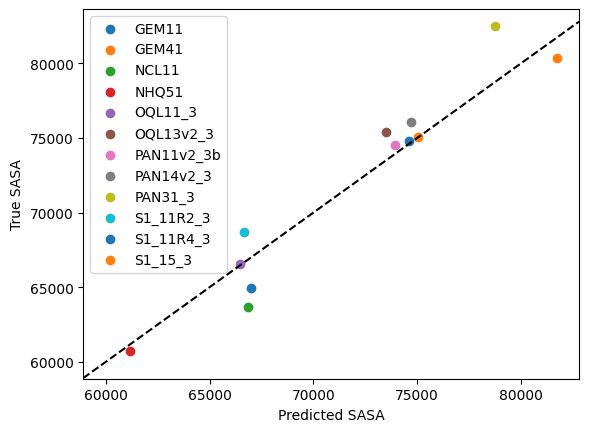

In [ ]:
plot_true_and_predicted_sasa(mbtr_model, sasa_model)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:03:29] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:03:30] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:03:31] WARNING: /workspace/src/learner.cc:873: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-pac

NAME PRED TRUE PERC
GEM11 78390.12 74784.6875 0.048210801007893496
GEM41 83150.555 80337.0703125 0.03502099795344712
NCL11 62458.62 63675.27734375 0.019107199854535382
NHQ51 59342.53 60745.85546875 0.023101563191778966
OQL11_3 67595.28 66567.953125 0.015432773230549892
OQL13v2_3 71308.36 75432.515625 0.054673455019086804
PAN11v2_3b 77509.72 74523.9375 0.04006472752462925
PAN14v2_3 75104.63 76080.1484375 0.0128222098015672
PAN31_3 83197.89 82504.890625 0.008399502074971692
S1_11R2_3 67374.125 68690.3203125 0.01916129239916332
S1_11R4_3 67374.27 64980.51953125 0.036838023511012584
S1_15_3 74141.695 75070.2578125 0.012369246184277583


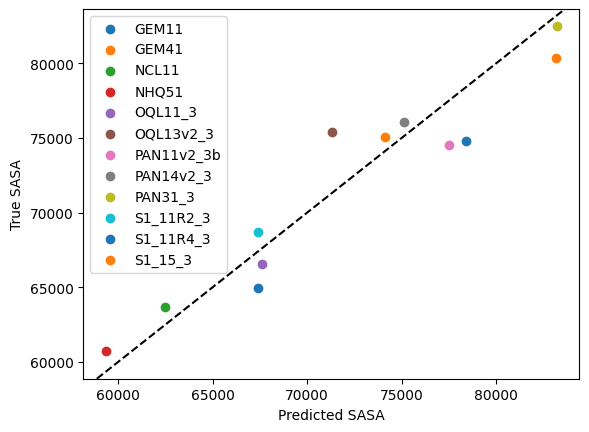

In [ ]:
mbtr_model = load_model('ensemble', 72, PROJECT_ROOT + '/models/ensemble/')
sasa_model = load_model('sasa_model', 72, PROJECT_ROOT + '/models/sasa_calculation_model/model')
plot_true_and_predicted_sasa(mbtr_model, sasa_model, baseline=True)